In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import matplotlib.pyplot as plt
from rff.layers import GaussianEncoding #pip install random-fourier-features-pytorch
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, recall_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
import seaborn as snss

import sys
import os
import importlib
sys.path.append('../../helpers/')
import helper
sys.path.append('../../model/')
from ourModel import Classifier, train, test
print(os.getcwd())

/home/aavila/CAT-Transformer/experiments/malware


In [2]:
# Run regardless if you do or do not have GPU so all tensors are moved to right location later on
if torch.cuda.is_available():
    device_in_use = torch.device("cuda")
    print("GPU is available and being used")
else:
    device_in_use = torch.device("cpu")
    print("GPU is not available, using CPU instead")

GPU is available and being used


In [3]:
importlib.reload(helper)
# df = pd.read_csv('../../datasets/MalwareData.csv', sep="|")
df = pd.read_csv('../../datasets/CIC_Mal/Obfuscated-MalMem2022_edited.csv')

# df.isna().any().any()

In [4]:
df

,Category,pslist.nproc,pslist.nppid,pslist.avg_threads,pslist.nprocs64bit,pslist.avg_handlers,dlllist.ndlls,dlllist.avg_dlls_per_proc,handles.nhandles,handles.avg_handles_per_proc,...,svcscan.kernel_drivers,svcscan.fs_drivers,svcscan.process_services,svcscan.shared_process_services,svcscan.interactive_process_services,svcscan.nactive,callbacks.ncallbacks,callbacks.nanonymous,callbacks.ngeneric,Class
0,Benign,45,17,10.555556,0,202.844444,1694,38.500000,9129,212.302326,...,221,26,24,116,0,121,87,0,8,Benign
1,Benign,47,19,11.531915,0,242.234043,2074,44.127660,11385,242.234043,...,222,26,24,118,0,122,87,0,8,Benign
2,Benign,40,14,14.725000,0,288.225000,1932,48.300000,11529,288.225000,...,222,26,27,118,0,120,88,0,8,Benign
3,Benign,32,13,13.500000,0,264.281250,1445,45.156250,8457,264.281250,...,222,26,27,118,0,120,88,0,8,Benign
4,Benign,42,16,11.452381,0,281.333333,2067,49.214286,11816,281.333333,...,222,26,24,118,0,124,87,0,8,Benign
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58591,Ransomware,37,15,10.108108,0,215.486487,1453,39.270270,7973,215.486487,...,221,26,24,116,0,120,86,0,8,Malware
58592,Ransomware,37,14,9.945946,0,190.216216,1347,36.405405,7038,190.216216,...,221,26,24,116,0,116,88,0,8,Malware
58593,Ransomware,38,15,9.842105,0,210.026316,1448,38.105263,7982,215.729730,...,221,26,24,116,0,120,88,0,8,Malware
58594,Ransomware,37,15,10.243243,0,215.513513,1452,39.243243,7974,215.513513,...,221,26,24,116,0,120,87,0,8,Malware


In [5]:
print(df.columns)
print(df.info())


Index(['Category', 'pslist.nproc', 'pslist.nppid', 'pslist.avg_threads',
       'pslist.nprocs64bit', 'pslist.avg_handlers', 'dlllist.ndlls',
       'dlllist.avg_dlls_per_proc', 'handles.nhandles',
       'handles.avg_handles_per_proc', 'handles.nport', 'handles.nfile',
       'handles.nevent', 'handles.ndesktop', 'handles.nkey', 'handles.nthread',
       'handles.ndirectory', 'handles.nsemaphore', 'handles.ntimer',
       'handles.nsection', 'handles.nmutant', 'ldrmodules.not_in_load',
       'ldrmodules.not_in_init', 'ldrmodules.not_in_mem',
       'ldrmodules.not_in_load_avg', 'ldrmodules.not_in_init_avg',
       'ldrmodules.not_in_mem_avg', 'malfind.ninjections',
       'malfind.commitCharge', 'malfind.protection',
       'malfind.uniqueInjections', 'psxview.not_in_pslist',
       'psxview.not_in_eprocess_pool', 'psxview.not_in_ethread_pool',
       'psxview.not_in_pspcid_list', 'psxview.not_in_csrss_handles',
       'psxview.not_in_session', 'psxview.not_in_deskthrd',
       'psxv

In [6]:
remove_columns = ["Class"]
# remove_columns = ['Category']

# legit = df[0:41323].drop(columns=remove_columns, axis=1)
# mal = df[41323::].drop(columns=remove_columns, axis=1)
df = df[~df.isin([np.nan, np.inf, -np.inf]).any(axis=1)]
# df
df = df[0::].drop(columns=remove_columns, axis=1)
df
# df.drop(columns=remove_columns, inplace=True)

,Category,pslist.nproc,pslist.nppid,pslist.avg_threads,pslist.nprocs64bit,pslist.avg_handlers,dlllist.ndlls,dlllist.avg_dlls_per_proc,handles.nhandles,handles.avg_handles_per_proc,...,svcscan.nservices,svcscan.kernel_drivers,svcscan.fs_drivers,svcscan.process_services,svcscan.shared_process_services,svcscan.interactive_process_services,svcscan.nactive,callbacks.ncallbacks,callbacks.nanonymous,callbacks.ngeneric
0,Benign,45,17,10.555556,0,202.844444,1694,38.500000,9129,212.302326,...,389,221,26,24,116,0,121,87,0,8
1,Benign,47,19,11.531915,0,242.234043,2074,44.127660,11385,242.234043,...,392,222,26,24,118,0,122,87,0,8
2,Benign,40,14,14.725000,0,288.225000,1932,48.300000,11529,288.225000,...,395,222,26,27,118,0,120,88,0,8
3,Benign,32,13,13.500000,0,264.281250,1445,45.156250,8457,264.281250,...,395,222,26,27,118,0,120,88,0,8
4,Benign,42,16,11.452381,0,281.333333,2067,49.214286,11816,281.333333,...,392,222,26,24,118,0,124,87,0,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58591,Ransomware,37,15,10.108108,0,215.486487,1453,39.270270,7973,215.486487,...,389,221,26,24,116,0,120,86,0,8
58592,Ransomware,37,14,9.945946,0,190.216216,1347,36.405405,7038,190.216216,...,389,221,26,24,116,0,116,88,0,8
58593,Ransomware,38,15,9.842105,0,210.026316,1448,38.105263,7982,215.729730,...,389,221,26,24,116,0,120,88,0,8
58594,Ransomware,37,15,10.243243,0,215.513513,1452,39.243243,7974,215.513513,...,389,221,26,24,116,0,120,87,0,8


In [7]:
target = ['Category']
# target = 
for x in df:
    print(df[x].value_counts())
    print("\n")

Category
Benign        29298
Spyware       10020
Ransomware     9791
Trojan         9487
Name: count, dtype: int64


pslist.nproc
41     10012
40      9226
42      7822
44      5777
43      5616
       ...  
106        1
122        1
132        1
161        1
96         1
Name: count, Length: 114, dtype: int64


pslist.nppid
12    16559
16    12242
15     8653
17     7898
13     4404
18     2827
14     2452
19     1294
20      537
8       446
11      334
21      229
9       203
22      184
10      133
23       55
24       29
25       27
37        9
39        8
38        8
26        8
40        6
62        5
27        5
28        4
60        4
36        3
52        3
54        3
66        2
49        2
55        2
56        2
48        2
72        1
61        1
57        1
34        1
42        1
50        1
35        1
53        1
43        1
33        1
44        1
63        1
51        1
41        1
Name: count, dtype: int64


pslist.avg_threads
10.000000    619
10.162162    502
10.1

In [8]:
# encode the labels of the targets and create decoding dict
label_encoders = []
encoded_to_labels = []
for x in range(len(target)):
    label_encoders.append(LabelEncoder())
    df[target[x]] = label_encoders[x].fit_transform(df[target[x]])
    encoded_to_labels.append({encoded: label for label, encoded in zip(label_encoders[x].classes_, label_encoders[x].transform(label_encoders[x].classes_))})



In [9]:
print(encoded_to_labels)

[{0: 'Benign', 1: 'Ransomware', 2: 'Spyware', 3: 'Trojan'}]


In [10]:
# dataset wrapper for the dataframe. Just a way to structure the data that pytorch likes and needs to then wrap with dataloader.

class DatasetWrapper(Dataset):
    def __init__(self, df : pd.DataFrame, target : str):
        self.n = df.shape[0]
        
        self.y = df[target].astype(np.int64).values

        self.scalar = StandardScaler()
        self.x = self.scalar.fit_transform(df.drop(columns=target)).astype(np.float32)

    def __len__(self):
        return self.n
    
    def __getitem__(self, index):
        return self.x[index], self.y[index]
    
exp_dataset = DatasetWrapper(df, target=target) # UPDATE for your experiments

# Split training and testing samples
train_size = int(0.8*len(exp_dataset)) # Use a different ratio if you want
test_size = len(exp_dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(exp_dataset, [train_size, test_size])

print(f"Train length: {len(train_dataset)}, Test length: {len(test_dataset)}") # See the ratios

batch_size = 256 #Hyperparameter that you should try messing with depending on the size of your dataset. The smaller it is, the more stochastic and chaotic the training gets.

# Wrapping with dataloader so that its easy to extract batches from the train and test subsets
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) 
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True) 

Train length: 46876, Test length: 11720


In [11]:
num_features =  len(train_dataset[0][0])
num_targets =   len(train_dataset[0][1])
classes_per_target = [len(df[t].unique()) for t in target ]

print(f"Features: {num_features}")
print(f"Targets: {num_targets}")
print(f"Classes per Target: {classes_per_target}")

Features: 55
Targets: 1
Classes per Target: [4]


In [12]:
#Updated with f1
model = Classifier(n_features=num_features, 
                                   pre_norm_on=True, 
                                   rff_on=True, 
                                   forward_expansion=1, 
                                   mlp_scale_classification=2, 
                                   targets_classes=classes_per_target
                                   ).to(device_in_use) # Instantiate the model


In [13]:
loss_functions = []
#This loop could easily be adapted to us BinaryCrossEntropy for binary class and Cross for multi class
for x in target:
    loss_functions.append(nn.CrossEntropyLoss())

optimizer = torch.optim.Adam(params=model.parameters(), lr = 0.001) # Maybe try messing around with optimizers. try other torch optimizers with different configurations.


In [14]:
epochs = 40 #Set the number of epochs

In [15]:
train_losses = []
test_losses = []
train_accuracies = [[] for _ in range(num_targets)]
test_accuracies =  [[] for _ in range(num_targets)]

for t in range(epochs):
  train_loss, train_accuracy = train(train_dataloader, model, loss_functions, optimizer, device_in_use=device_in_use)
  test_loss, test_accuracy, all_predictions, all_targets, f1 = test(test_dataloader, model, loss_functions, device_in_use=device_in_use)

  #Losses
  train_losses.append(train_loss)
  test_losses.append(test_loss)
  #Accuracies
  for i in range(num_targets):
    train_accuracies[i].append(train_accuracy[i])
    test_accuracies[i].append(test_accuracy[i])
 
  # Formatting for easier reading
  epoch_str = f"Epoch [{t+1:2}/{epochs}]"

  train_metrics = f"Train: Loss {train_loss:.2f}"
  for target, Acc in zip(target, train_accuracy):
    train_metrics += f", {target} Accuracy: {Acc:.2f}"
  
  test_metrics = f"Test: Loss {test_loss:.2f}"
  for target, Acc, fone in zip(target, test_accuracy, f1):
    test_metrics += f", {target} Accuracy: {Acc:.2f}, {target} F1: {fone:.2f}"

  print(f"{epoch_str:15} | {train_metrics} | {test_metrics}")


Epoch [ 1/40]   | Train: Loss 0.69, Category Accuracy: 0.64 | Test: Loss 0.53, C Accuracy: 0.72, C F1: 0.68
Epoch [ 2/40]   | Train: Loss 0.50, C Accuracy: 0.75 | Test: Loss 0.49, C Accuracy: 0.76, C F1: 0.75
Epoch [ 3/40]   | Train: Loss 0.47, C Accuracy: 0.78 | Test: Loss 0.46, C Accuracy: 0.78, C F1: 0.78
Epoch [ 4/40]   | Train: Loss 0.44, C Accuracy: 0.79 | Test: Loss 0.44, C Accuracy: 0.79, C F1: 0.79
Epoch [ 5/40]   | Train: Loss 0.43, C Accuracy: 0.80 | Test: Loss 0.43, C Accuracy: 0.81, C F1: 0.80
Epoch [ 6/40]   | Train: Loss 0.42, C Accuracy: 0.81 | Test: Loss 0.42, C Accuracy: 0.81, C F1: 0.81
Epoch [ 7/40]   | Train: Loss 0.41, C Accuracy: 0.81 | Test: Loss 0.42, C Accuracy: 0.81, C F1: 0.81
Epoch [ 8/40]   | Train: Loss 0.41, C Accuracy: 0.81 | Test: Loss 0.41, C Accuracy: 0.81, C F1: 0.81
Epoch [ 9/40]   | Train: Loss 0.40, C Accuracy: 0.82 | Test: Loss 0.41, C Accuracy: 0.81, C F1: 0.81
Epoch [10/40]   | Train: Loss 0.40, C Accuracy: 0.82 | Test: Loss 0.41, C Accuracy: 

/tmp/ipykernel_16369/4134966633.py:25: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


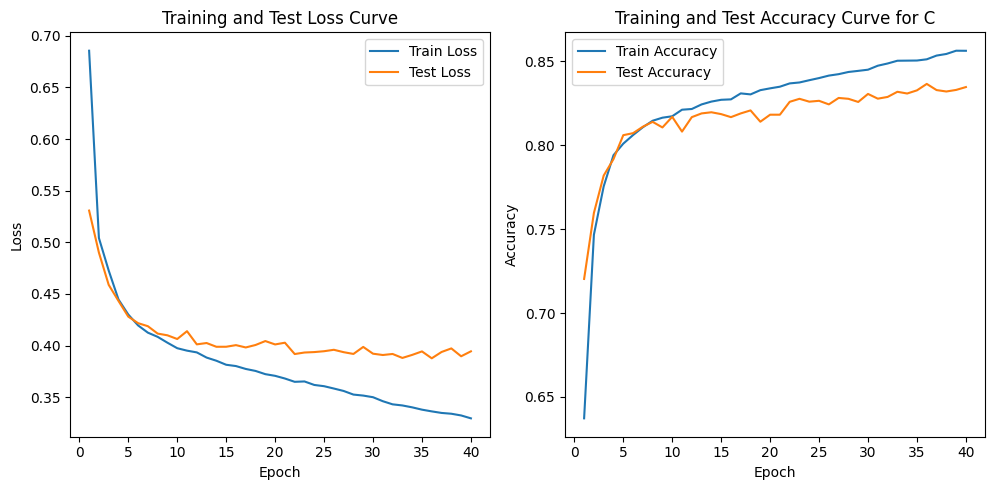

In [16]:
plot_num = 1
# Plotting the loss curves
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, plot_num)
plt.plot(range(1, epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, epochs+1), [l for l in test_losses], label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss Curve')
plt.legend()
plot_num+=1

for i in range(num_targets):
    plt.subplot(1, 3, plot_num)
    plt.plot(range(1, epochs+1), train_accuracies[i], label='Train Accuracy')
    plt.plot(range(1, epochs+1), test_accuracies[i], label='Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title(f'Training and Test Accuracy Curve for {target[i]}')
    plt.legend()
    plot_num+=1


plt.tight_layout()
plt.tight_layout()
plt.show()
